# Eindopdracht Tijdreeksen 2122
Ymke van der Waal en Lea van den Heuvel

**De opdracht:**

**Duurzame energie is hot. Maak een voorspellingsmodel dat 1 week vooruit voorspelt wat het energieverbruik door zonnepanelen is. Hanteer hierbij als maatstaf MAPE. Beschrijf de invloed van de weersvariabelen op het energieverbruik door zonnepanelen.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import dateparser
from datetime import timedelta
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
import datetime

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['image.cmap']='Paired'
np.random.seed(42)

# 1 Data importeren en eerste bewerkingen

### 1.1 Energie data
Als je de data download gaat het niet verder dan twee jaar terug, dus moeten we een eerder gedownloade dataset samenvoegen met een dataset van later.

Variabelen:
- Stroom 1 (in kWh): Electricitreitsverbruik, gemeten bij meter 1
- Stroom 2 (in kWh): Electricitreitsverbruik, gemeten bij meter 2
- Teruglevering 1 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 1
- Teruglevering 2 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 2
- Gas 1 (in m3): Gasverbruik
- Opmerkingen

#### 1.1.1 Eerste dataset

In [3]:
# Eerste dataset
ts1 = pd.read_csv('mijn-meterstanden.csv')
ts1.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,25 mei 2021,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,24 mei 2021,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,23 mei 2021,9.153,8.999,807.0,2.009,6.927,Smartmeter


In [4]:
# Zet datum om
ts1['Meetdatum'] = ts1.Meetdatum.apply(lambda x: dateparser.parse(x))
ts1.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-25,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,2021-05-24,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,2021-05-23,9.153,8.999,807.0,2.009,6.927,Smartmeter


#### 1.1.2 Tweede dataset

In [5]:
# Tweede dataset
ts2 = pd.read_csv('mijn-meterstanden_3.csv')
ts2.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,31 mei 2021,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,30 mei 2021,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,29 mei 2021,9.177,9.019,823.0,2.067,6.934,Smartmeter


In [6]:
# Zet datum om
ts2['Meetdatum'] = ts2.Meetdatum.apply(lambda x: dateparser.parse(x))
ts2.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter


#### 1.1.3 Samenvoegen

In [7]:
# Voeg de twee datasets samen
ts = ts2[ts2.Meetdatum > ts1.Meetdatum.max()] # Set met data die extra worden toegevoegd aan ts1
ts = pd.concat([ts, ts1]) # Voeg de twee sets samen
ts.head(10)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter
3,2021-05-28,9.176,9.017,823.0,2.042,6.934,Smartmeter
4,2021-05-27,9.175,9.014,823.0,2.033,6.932,Smartmeter
5,2021-05-26,9.174,9.004,823.0,2.022,6.931,Smartmeter
0,2021-05-25,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,2021-05-24,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,2021-05-23,9.153,8.999,807.0,2.009,6.927,Smartmeter
3,2021-05-22,9.146,8.999,799.0,2.009,6.925,Smartmeter


#### 1.1.4 Data inspecteren

In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 756
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meetdatum              763 non-null    datetime64[ns]
 1   Stroom 1 (kWh)         763 non-null    float64       
 2   Stroom 2 (kWh)         763 non-null    float64       
 3   Teruglevering 1 (kWh)  342 non-null    float64       
 4   Teruglevering 2 (kWh)  344 non-null    float64       
 5   Gas 1 (m3)             763 non-null    float64       
 6   Opmerkingen            763 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 47.7+ KB


In [9]:
def check_dates(x):
    '''Functie om te checken of datum vóór en na in ts staan, zodat het gefilterd kan worden en het een timeseries is
    Returned boolean, True wanneer datum vóór en na gecheckte datum in de dataframe staan'''
    d = timedelta(days=1)
    # Check of dag ervoor en dag erna in ts staan, dan is het ts
    if ((x-d) in ts.Meetdatum.values) and ((x+d) in ts.Meetdatum.values):
        return True
    else: return False

In [10]:
# Nieuwe kolom met of de datum ervoor en erna in ts staan
ts['check_dates'] = ts['Meetdatum'].apply(lambda x: check_dates(x))
ts.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen,check_dates
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter,False
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter,True
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter,True


In [11]:
ts = ts[ts['check_dates']] # Behoud alleen rijen waarbij de dag ervoor en erna ook in de dataset staan
ts.drop(columns = ['Opmerkingen', 'check_dates'], inplace = True) # Drop onnodige kolommen
ts.set_index('Meetdatum', inplace =True) # Set index
ts.head(3)

,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3)
Meetdatum,,,,,
2021-05-30,9.181,9.019,843.0,2.067,6.935
2021-05-29,9.177,9.019,823.0,2.067,6.934
2021-05-28,9.176,9.017,823.0,2.042,6.934


In [12]:
# Door het excel format zijn alle getallen groter dan 1000 omgezet naar floats
# Het zijn geen floats maar integers, dus alle getallen boven de 1000 moeten worden vermenigvuldigd met 1000
cols = [ 'Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)', 'Teruglevering 2 (kWh)', 'Gas 1 (m3)']

for col in cols:
    ts[col] = ts[col].apply(lambda x: (x*1000) if (x < 10) else x)
    
ts.head(3)

,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3)
Meetdatum,,,,,
2021-05-30,9181.0,9019.0,843.0,2067.0,6935.0
2021-05-29,9177.0,9019.0,823.0,2067.0,6934.0
2021-05-28,9176.0,9017.0,823.0,2042.0,6934.0


In [13]:
# Nieuwe kolommen
# Stroom in kWh
ts['stroom'] = ts['Stroom 1 (kWh)'] + ts['Stroom 2 (kWh)']
# Teruglevering in kWh
ts['teruglevering'] = ts['Teruglevering 1 (kWh)'] + ts['Teruglevering 2 (kWh)']
# Gas in m3
ts.rename(columns = {'Gas 1 (m3)': 'gas'}, inplace = True)
# Filter nodige kolommen
ts = ts[['gas', 'stroom', 'teruglevering']].copy()
ts.head(3)

,gas,stroom,teruglevering
Meetdatum,,,
2021-05-30,6935.0,18200.0,2910.0
2021-05-29,6934.0,18196.0,2890.0
2021-05-28,6934.0,18193.0,2865.0


In [14]:
ts.describe()

,gas,stroom,teruglevering
count,735.000000,735.000000,338.000000
mean,5354.122449,14913.485714,1578.597633
std,846.942378,2121.267077,641.287872
min,4154.000000,11088.000000,0.000000
25%,4527.000000,12998.000000,1329.250000
50%,5494.000000,15372.000000,1641.000000
75%,5775.500000,16616.500000,1901.250000
max,6935.000000,18200.000000,2910.000000


In [15]:
# Missende waarden
ts.isna().sum()

gas                0
stroom             0
teruglevering    397
dtype: int64

In [16]:
ts[ts['teruglevering'].isnull()]
# Er zijn missende waarden omdat er toen nog geen zonnepanelen (=teruglevering) was

,gas,stroom,teruglevering
Meetdatum,,,
2020-06-27,5508.0,15666.0,NaN
2020-06-26,5508.0,15664.0,NaN
2020-06-25,5507.0,15661.0,NaN
2020-06-24,5507.0,15644.0,NaN
2020-06-23,5507.0,15638.0,NaN
...,...,...,...
2019-05-31,4156.0,11139.0,NaN
2019-05-30,4156.0,11119.0,NaN
2019-05-29,4155.0,11113.0,NaN


In [17]:
# Duplicates bekijken
ts[ts.duplicated()]

,gas,stroom,teruglevering
Meetdatum,,,


In [18]:
# Opslaan als csv
# ts.to_csv('energieverbruik_v2.csv')

### 1.2 Weer data 

De data:

- Datum
- Etmaalgemiddelde temperatuur in 0.1 graden Celcius
- Zonneschijnduur in 0.1 uur
- Duur van neerslag in 0.1 uur
- Etmaalsom van de neerslag in 0.1 mm

In [19]:
ts_weer = pd.read_csv('Weer_data.csv')
ts_weer.head(3)

,YYYYMMDD,TG,SQ,DR,RH
0,1991-08-13,147,8,0,-1
1,1991-08-14,162,91,0,0
2,1991-08-15,181,94,0,0


In [20]:
ts_weer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774 entries, 0 to 10773
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   YYYYMMDD  10774 non-null  object
 1   TG        10774 non-null  int64 
 2   SQ        10774 non-null  int64 
 3   DR        10774 non-null  int64 
 4   RH        10774 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 421.0+ KB


In [21]:
ts_weer.columns

Index(['YYYYMMDD', 'TG', 'SQ', 'DR', 'RH'], dtype='object')

In [22]:
# Rename columns
weer_colnames = {'YYYYMMDD' : 'Date', 'TG' : 'temp', 'SQ' : 'zonneschijn', 
                 'DR' : 'duur_neerslag', 'RH' : 'som_neerslag'}
ts_weer.rename(columns = weer_colnames, inplace = True)
# Date als datetime
ts_weer['Date'] = pd.to_datetime(ts_weer['Date'], format = '%Y-%m-%d')
#Set date als index
ts_weer.set_index('Date', inplace = True)
ts_weer.head(3)

,temp,zonneschijn,duur_neerslag,som_neerslag
Date,,,,
1991-08-13,147,8,0,-1
1991-08-14,162,91,0,0
1991-08-15,181,94,0,0


### 1.3 Datasets mergen

In de datasets die we gaan gebruiken stata dus:

- Gasverbruik (in m3)
- Stroomverbruik (in kWh)
- **Teruglevering stroom (in kWh) is Y**
- Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
- Zonneschijnduur (in 0.1 uur)
- Duur van de neerslag (in 0.1 uur) 
- Etmaalsom van de neerslag (in 0.1 mm) 

In [23]:
ts = ts.merge(ts_weer, 
              left_index = True, right_index = True,
              how = 'inner') # Alleen data mergen die in beide sets voorkomen
ts.head(3)

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,6935.0,18200.0,2910.0,142,147,0,0
2021-05-29,6934.0,18196.0,2890.0,116,73,0,0
2021-05-28,6934.0,18193.0,2865.0,121,124,0,0


## 2 Visualisaties

In [24]:
# Kolommen verdelen
cols_e = ['gas', 'stroom', 'teruglevering']
cols_w = ['temp', 'zonneschijn', 'duur_neerslag', 'som_neerslag']

### 2.1 Energieverbruik

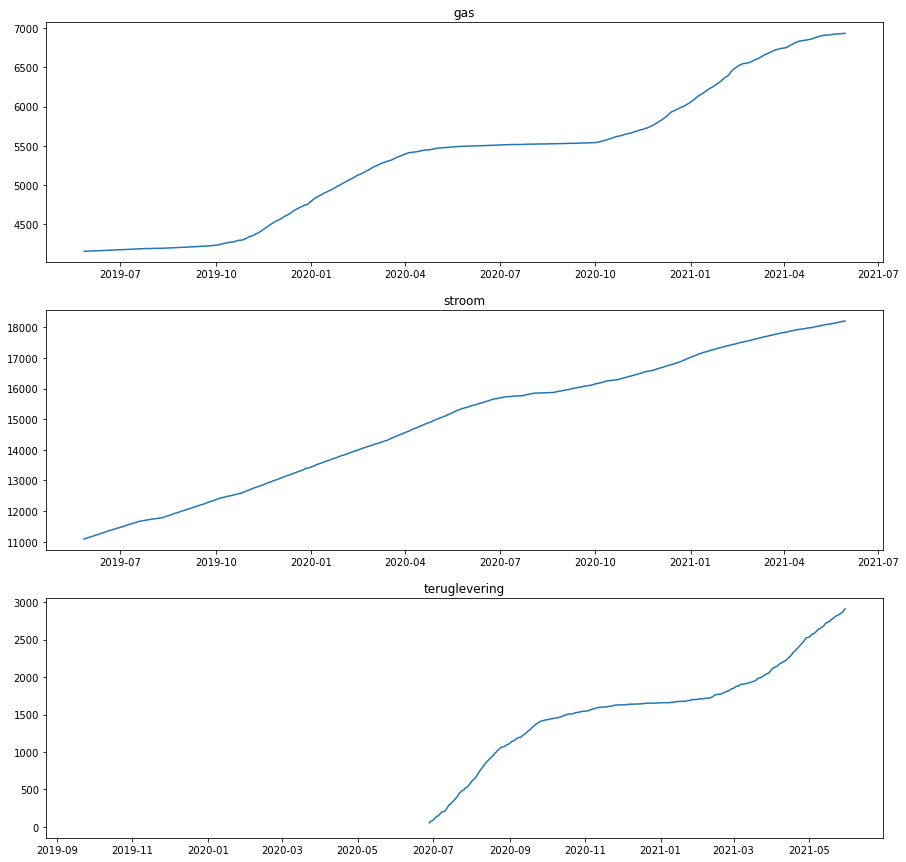

In [25]:
fig, ax = plt.subplots(3,1, figsize = (15,15))

for col in cols_e:
    i = cols_e.index(col)
    ax[i].plot(ts[col])
    ax[i].set_title(col)
    
plt.show()

In [26]:
# Meter is cumulatief dus differentieren om gebruik per dag te krijgen
# Absolute waardes pakken
ts[cols_e] = np.abs(ts[cols_e].diff())
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,NaN,NaN,NaN,142,147,0,0
2021-05-29,1.0,4.0,20.0,116,73,0,0
2021-05-28,0.0,3.0,25.0,121,124,0,0
2021-05-27,2.0,4.0,9.0,109,34,84,75
2021-05-26,1.0,11.0,11.0,109,52,59,61


<Figure size 1080x576 with 0 Axes>

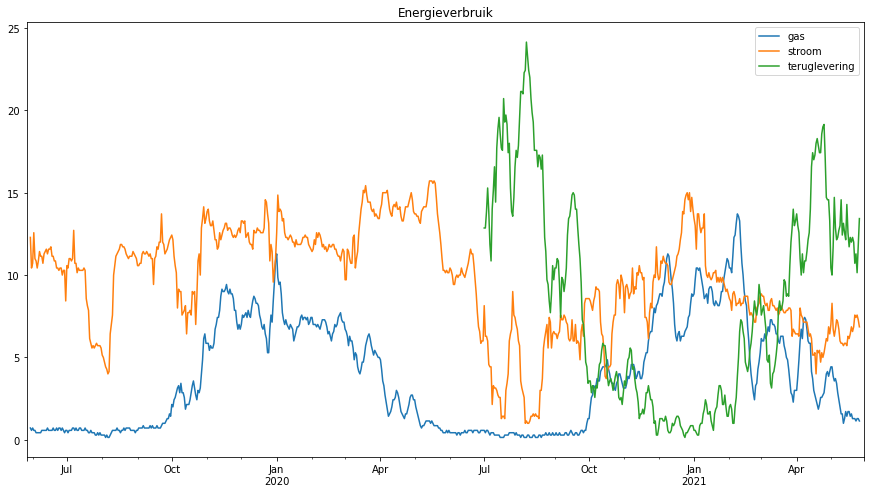

In [27]:
plt.set_cmap('Paired')

ts_rolling = ts[cols_e].rolling(window = 7, center = True).mean()
ts_rolling.plot()
plt.title('Energieverbruik')
plt.legend()
plt.show()

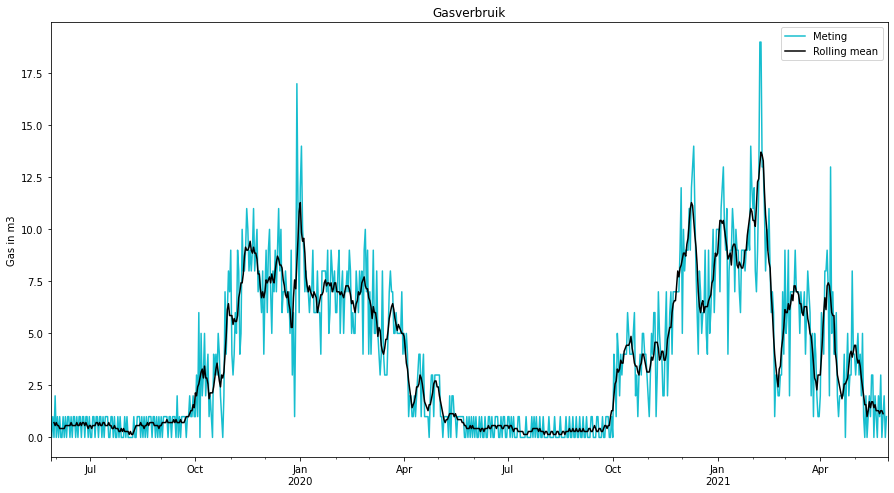

In [28]:
ts['gas'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['gas'].rolling(window = 7, center = True).mean()
ts_rolling['gas'].plot(color = "k", label = "Rolling mean")

plt.title('Gasverbruik')
plt.ylabel('Gas in m3')
plt.legend()
plt.show()

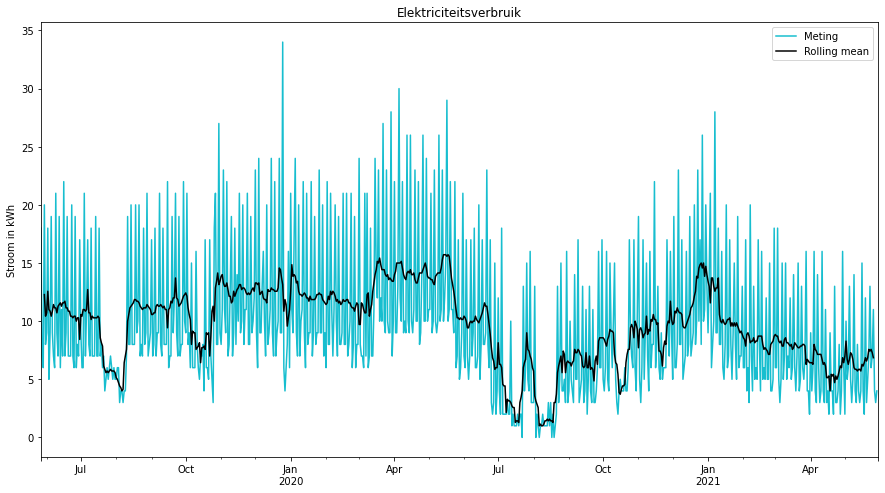

In [29]:
ts['stroom'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['stroom'].rolling(window = 7, center = True).mean()
ts_rolling['stroom'].plot(color = "k", label = "Rolling mean")

plt.title('Elektriciteitsverbruik')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

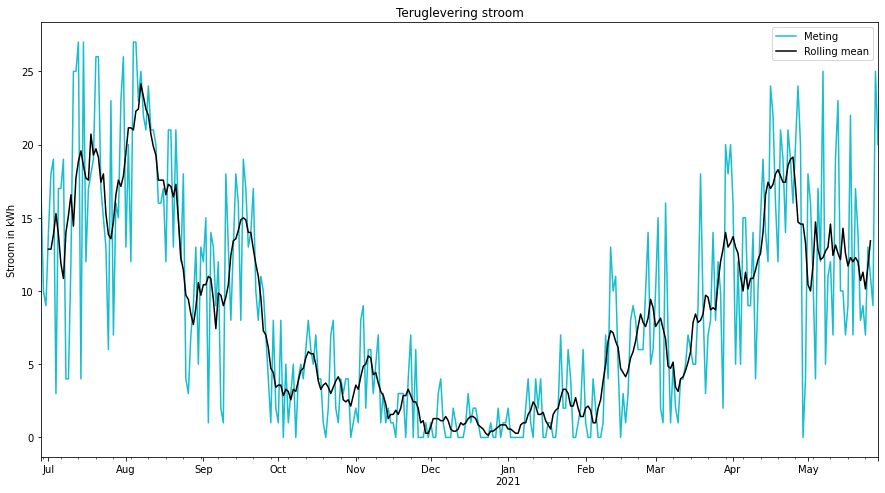

In [30]:
ts['teruglevering'].dropna().plot(color = 'tab:cyan', label = 'Meting')

# ts_mean = ts['teruglevering'].dropna().rolling(window = 7, center = True).mean()
ts_rolling['teruglevering'].dropna().plot(color = "k", label = "Rolling mean")

plt.title('Teruglevering stroom')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

#### 2.1.1 Verdeling van de data

In [31]:
def season(x):
    '''Input is de maand, returned in welk seizoen de maand is'''
    
    if x == 12 or x <= 2:
        return "Winter"
    elif x >= 8:
        return "Autumn"
    elif x >= 6:
        return "Summer"
    else: return "Spring"

In [32]:
# Nieuwe kolom voor dag vd week
ts['day_of_week'] = ts.index.dayofweek
ts['day_of_week_name'] = ts.index.day_name()
# kolom met dag vd maand
ts['day_of_month'] = ts.index.day
# kolom met maand
ts['month'] = ts.index.month 
ts['month_name'] = ts.index.month_name()
 # kolom met seizoen
ts['season'] = ts['month'].apply(lambda x: season(x))
ts['season'] = ts['season'].astype('category')
ts.head(3)

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season
2021-05-30,NaN,NaN,NaN,142,147,0,0,6,Sunday,30,5,May,Spring
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring


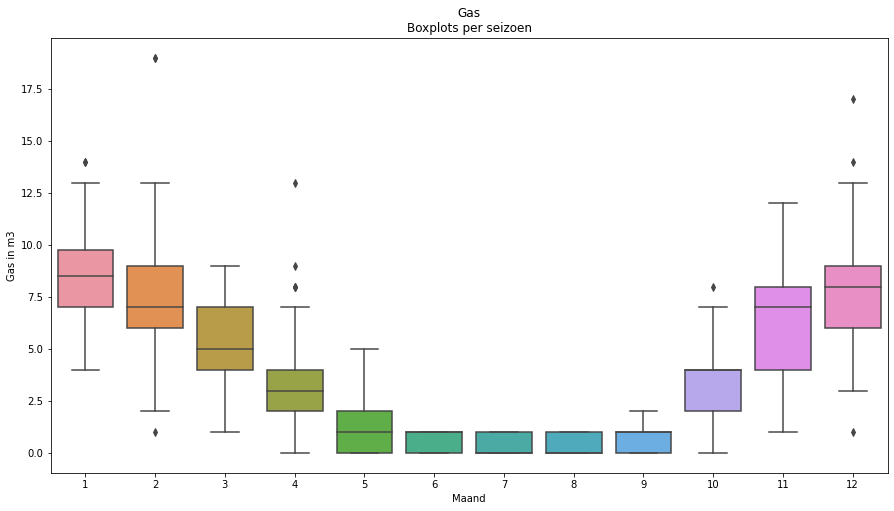

In [33]:
sns.boxplot(data = ts, y = 'gas', x = 'month')
plt.title('Gas\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Gas in m3')
plt.show()

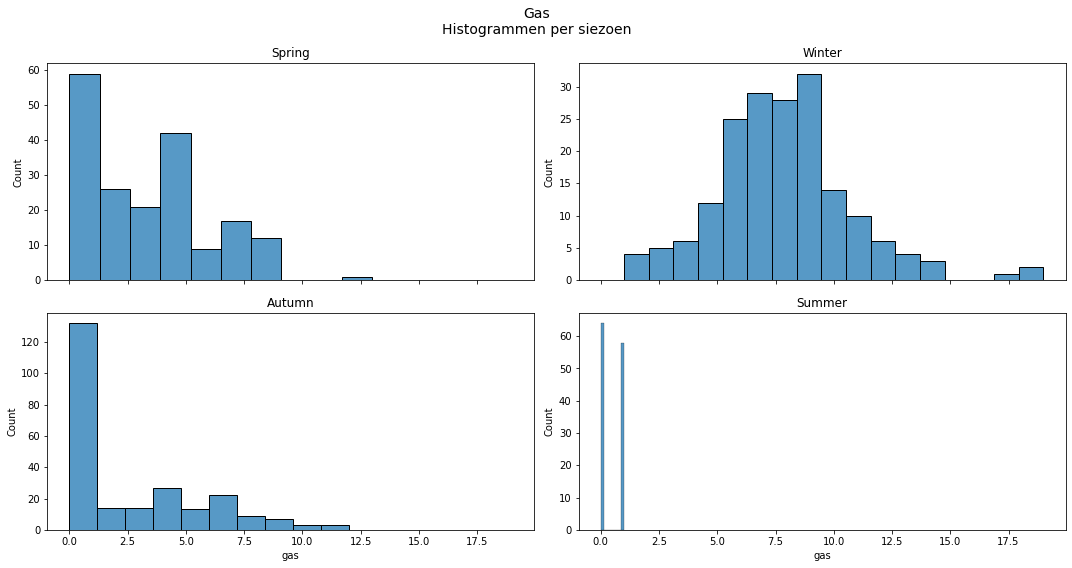

In [34]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'gas',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Gas\nHistogrammen per siezoen', size = 14)
plt.tight_layout()
plt.show()

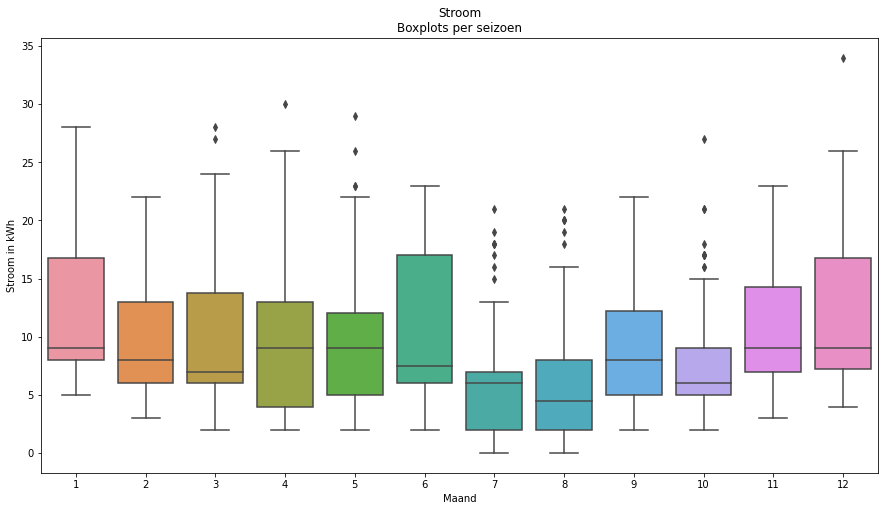

In [35]:
sns.boxplot(data = ts, y = 'stroom', x = 'month')
plt.title('Stroom\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

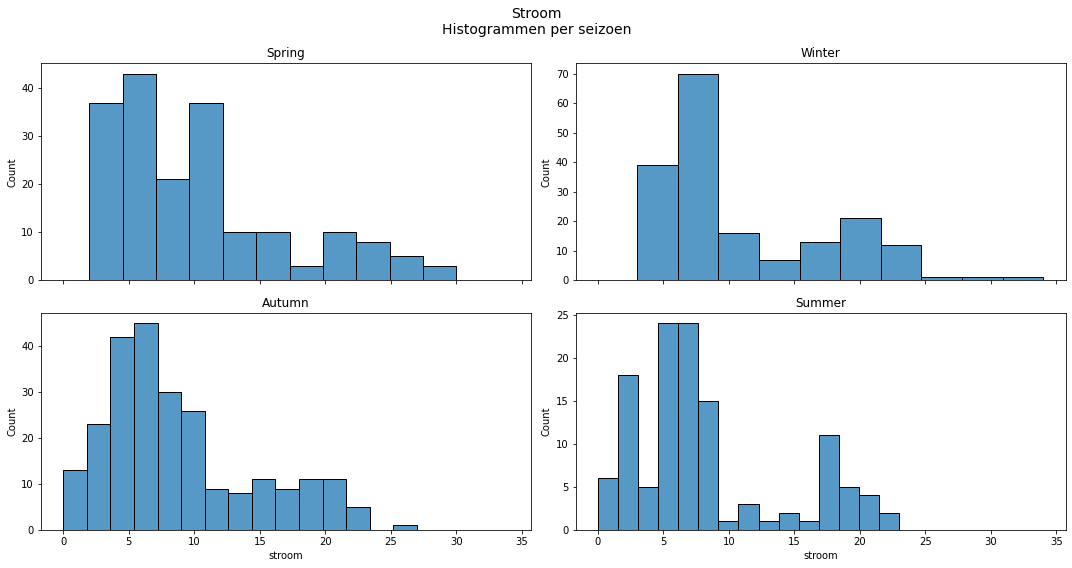

In [36]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'stroom',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Stroom\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

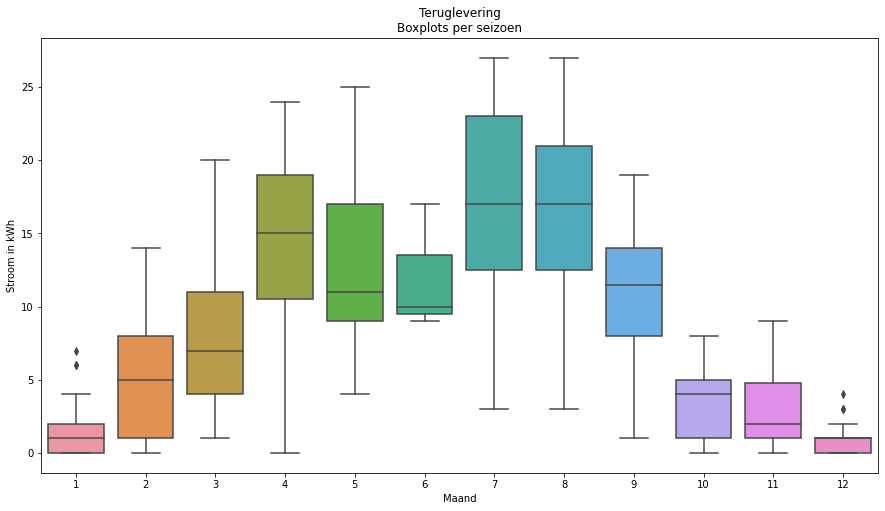

In [37]:
sns.boxplot(data = ts, y = 'teruglevering', x = 'month')
plt.title('Teruglevering\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

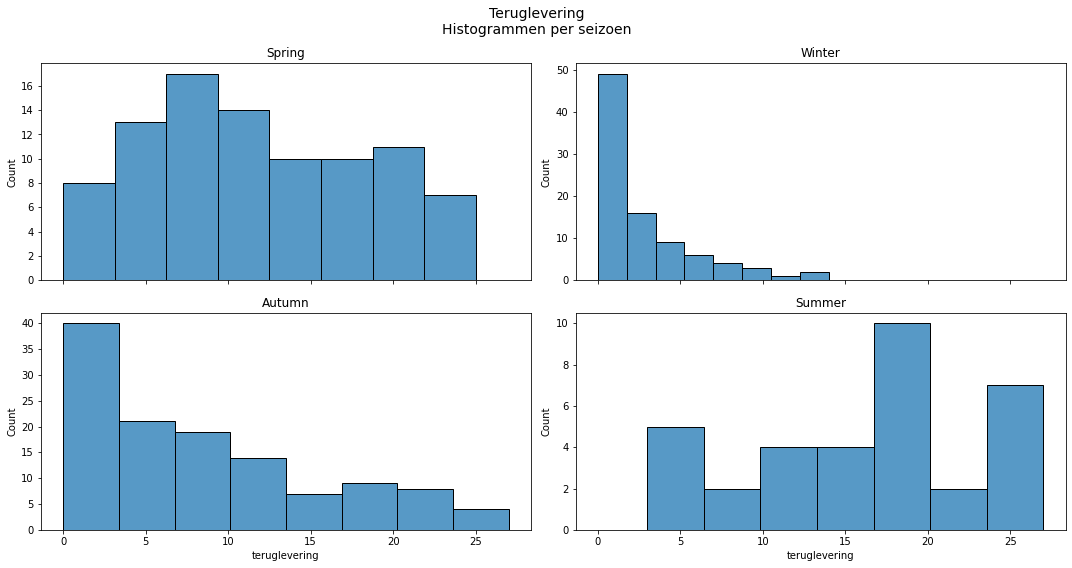

In [38]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'teruglevering',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Teruglevering\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

#### 2.1.2 Gemiddelden

In [39]:
# Labels voor legenda
legend_labels_e = ['Gasverbruik (m3)', 'Stroomverbruik (kWh)', 'Teruglevering stroom (kWh)']

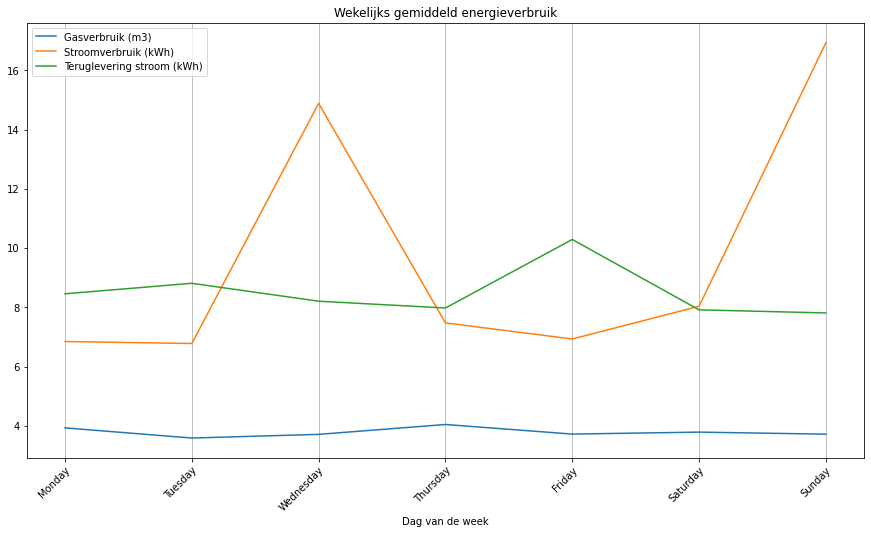

In [40]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_e].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

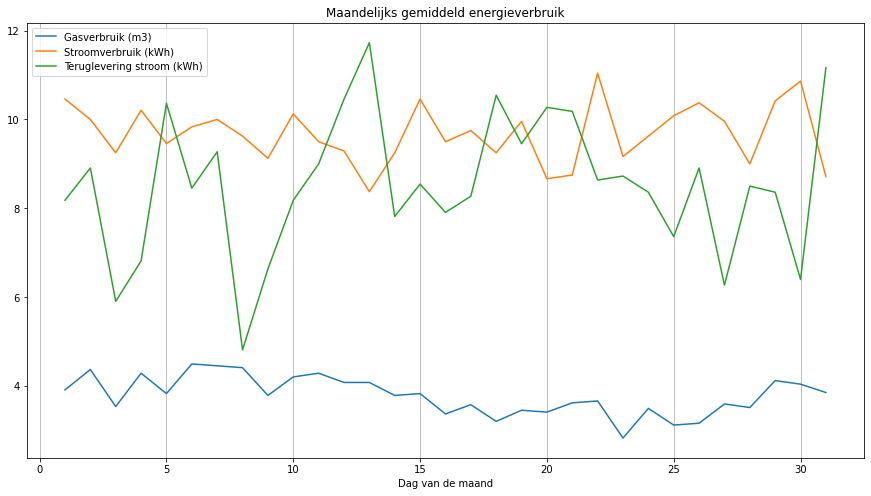

In [41]:
ts_grouped_gas = ts.groupby('day_of_month')[cols_e].mean()
ax = ts_grouped_gas.plot()
plt.title('Maandelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

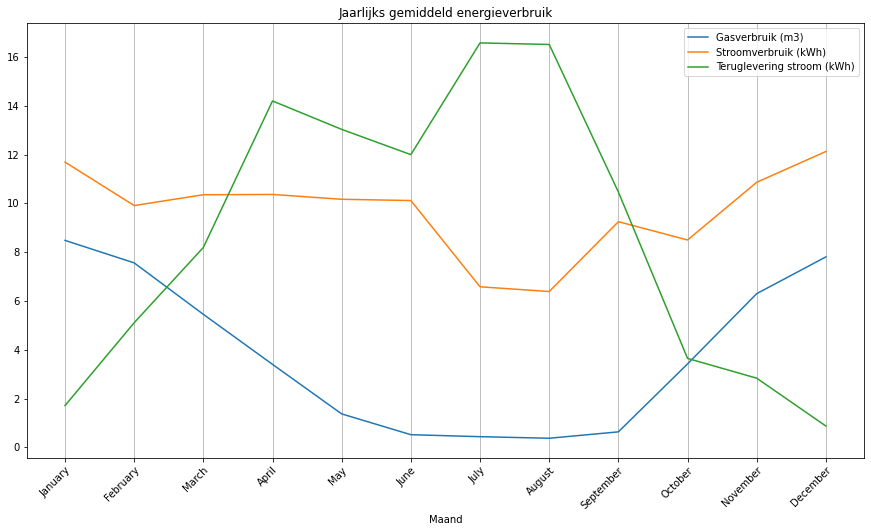

In [42]:
ts_grouped_gas = ts.groupby(['month', 'month_name'])[cols_e].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_gas.plot()
plt.title('Jaarlijks gemiddeld energieverbruik')
plt.xticks(np.arange(1, 13),
           ts_grouped_gas['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.xlabel('Maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

Teruglevering heeft een duidelijk jaarlijks seizoenspatroon. ARIMA kan één seizoenspatroon aan, dus er worden geen fourier terms toegevoegd.

### 2.2 Weer data

In [43]:
# Dataset met moving average voor weer data
ts_rolling_w = ts[cols_w].rolling(window = 7, center = True).mean()
ts_rolling_w.head(10)

,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,NaN,NaN,NaN,NaN
2021-05-29,NaN,NaN,NaN,NaN
2021-05-28,NaN,NaN,NaN,NaN
2021-05-27,116.857143,68.714286,37.571429,35.285714
2021-05-26,112.142857,52.571429,38.857143,36.142857
2021-05-25,110.428571,43.428571,46.857143,43.142857
2021-05-24,111.428571,36.714286,49.285714,46.000000
2021-05-23,113.142857,39.142857,38.000000,35.571429
2021-05-22,111.857143,35.285714,31.857143,28.857143
2021-05-21,112.142857,42.428571,31.000000,32.142857


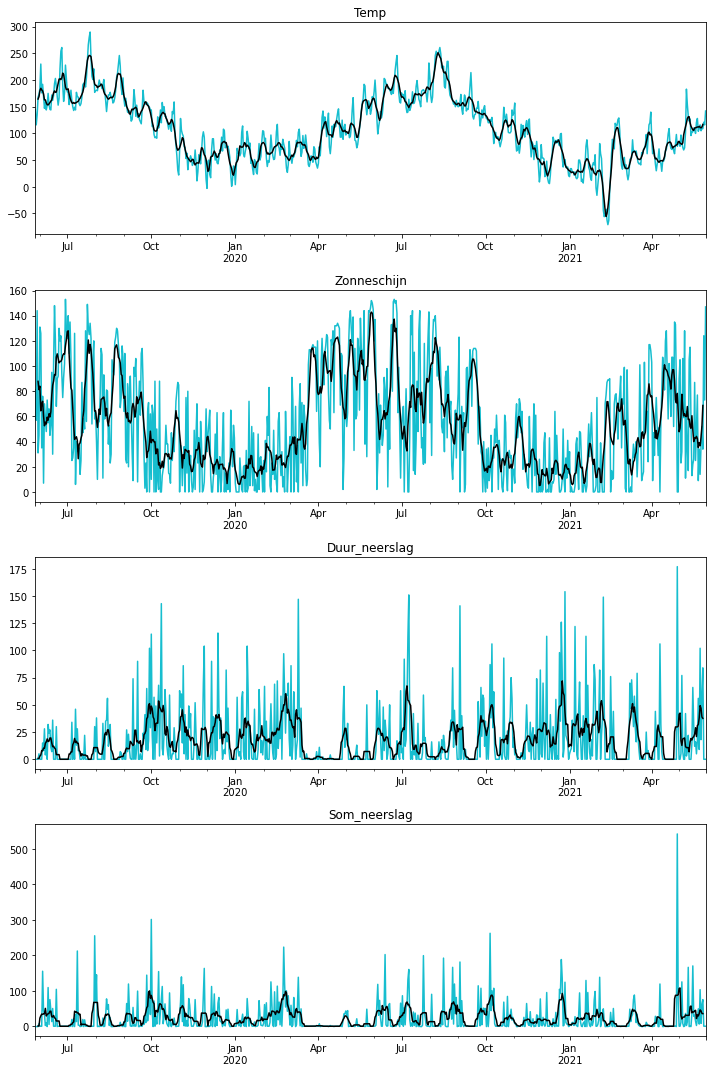

In [44]:
# Plot weer data met rolling mean
fig, ax = plt.subplots(4,1, figsize = (10,15))
# Dictionairy voor variabele met bijbehorende ax
dict_ax = {'temp' : ax[0],
           'zonneschijn' : ax[1],
           'duur_neerslag' : ax[2],
           'som_neerslag' : ax[3],
          }

for i in cols_w:
    # Plot originele data
    ts[i].plot(color = 'tab:cyan', label = 'Meting', 
               ax = dict_ax[i])
    # Plot rolling mean
    ts_rolling_w[i].plot(color = "k", label = "Rolling mean",
                         ax = dict_ax[i])
    dict_ax[i].set_title(i.capitalize())
    
plt.tight_layout()
plt.show()

#### 2.2.1 Gemiddelden

In [45]:
# Labels voor in legenda
legend_labels_w = ['Temperatuur (0.1 graden Celsius)', 'Zonneschijnduur (0.1 uur)',
                   'Duur neerslag (0.1 uur)', 'Som neerslag (0.1 mm)']

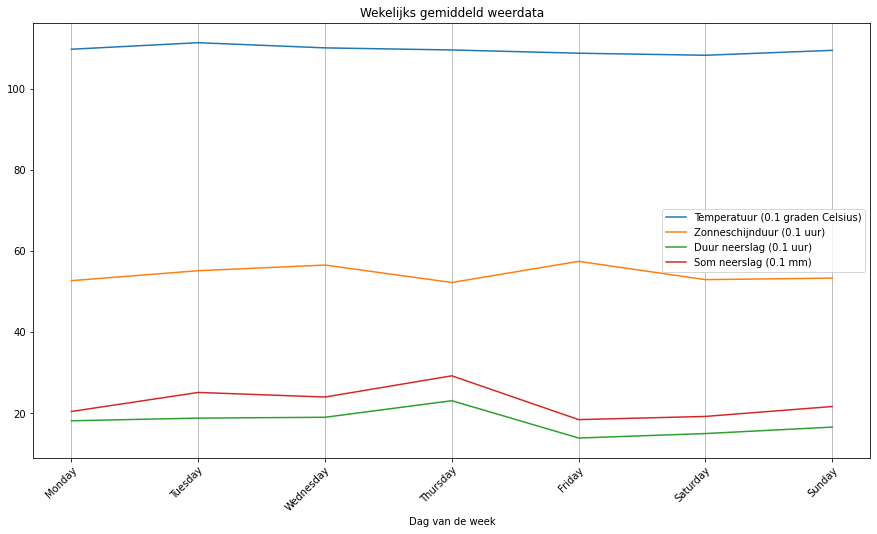

In [46]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_w].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld weerdata')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

ax.legend(legend_labels_w)
plt.grid(axis = 'x')
plt.show()

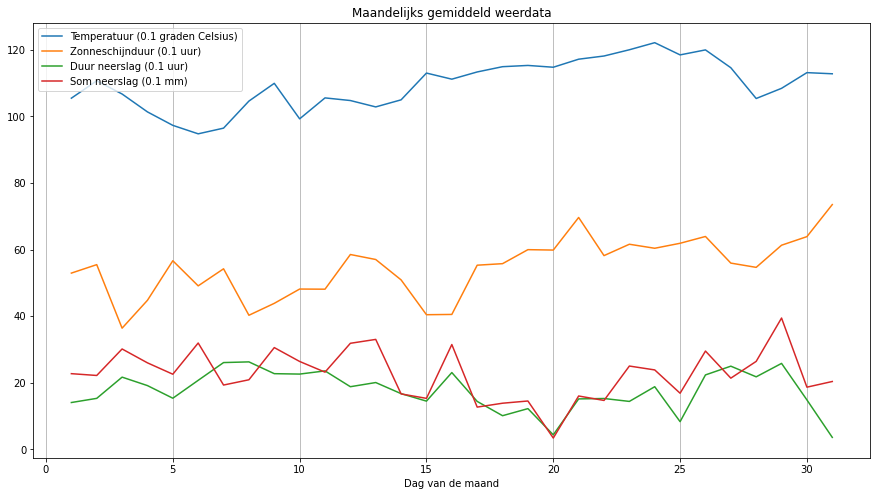

In [47]:
ts_grouped_w = ts.groupby('day_of_month')[cols_w].mean()#.reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Maandelijks gemiddeld weerdata')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

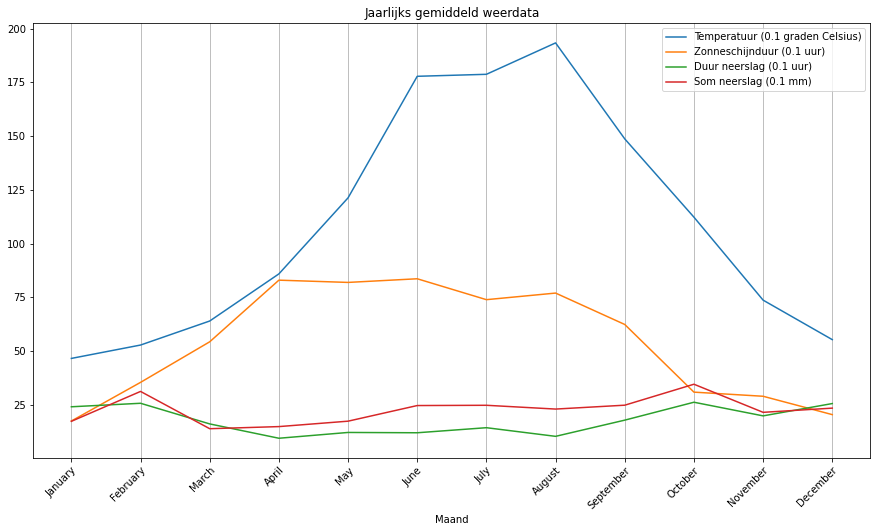

In [48]:
ts_grouped_w = ts.groupby(['month', 'month_name'])[cols_w].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Jaarlijks gemiddeld weerdata')
plt.xticks(np.arange(1, 13),
           ts_grouped_w['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')
plt.xlabel('Maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

Weerdata heeft alleen jaarlijks seizoenspatroon.

### 2.3 Zonnepanelen en weer data samen

#### 2.3.1 Correlatie

In [49]:
# Drop NaN waarden, er zijn veel NaN waarden voor teruglevering omdat die later kwamen dan het gebruik van gas startte
ts.dropna(inplace = True)

In [50]:
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring
2021-05-27,2.0,4.0,9.0,109,34,84,75,3,Thursday,27,5,May,Spring
2021-05-26,1.0,11.0,11.0,109,52,59,61,2,Wednesday,26,5,May,Spring
2021-05-25,0.0,7.0,13.0,105,37,18,8,1,Tuesday,25,5,May,Spring


In [51]:
# Nummerieke kolommen
cols = ['gas', 'stroom', 'teruglevering', 
        'temp', 'zonneschijn','duur_neerslag', 'som_neerslag']

In [52]:
# Correlatie van teruglevering met de andere variabelen, gesorteerd van positief naar negatief
ts_corr = ts[cols].corr()
corr_teruglevering = ts_corr.drop('teruglevering')[['teruglevering']].sort_values('teruglevering', ascending = False)
corr_teruglevering

,teruglevering
zonneschijn,0.881190
temp,0.516625
som_neerslag,-0.229179
duur_neerslag,-0.389007
stroom,-0.489764
gas,-0.611261


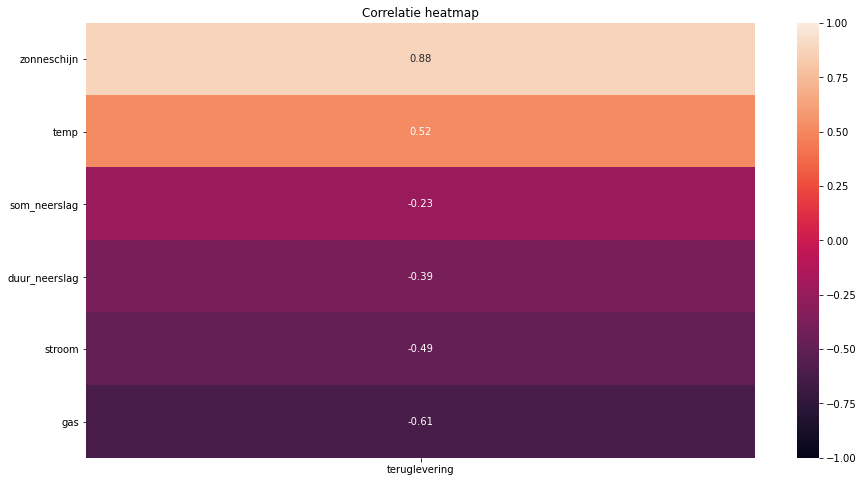

In [53]:
sns.heatmap(corr_teruglevering, annot = True, 
            vmin=-1, vmax=1 # Set range van kleur
           )
plt.title('Correlatie heatmap')
plt.yticks(rotation = 'horizontal')
plt.show()

In [54]:
ts_corr.loc['temp', 'zonneschijn']

0.33699956854806656

Teruglevering heeft een hoge positieve correlatie met zonneschijn en temperatuur, dus kunnen als extra variabelen toegevoegd worden aan het ARIMA model. Temperatuur en zonneschijn hebben een correlatie van 0.33, redelijk lage correlatie dus geen multicollineariteit.

Gas en stroom worden niet gebruikt om teruglevering te voorspellen; er wordt een weersvoorspelling gedaan voor dus op basiss daarvan kunnen we teruglevering voorspellen. Gas- en elektriciteitsverbruik is pas bekend aan het einde van de dag, en niet op het moment dat een voorspelling gedaan wordt.

#### 2.3.2 Verdere visualisaties met temperatuur en zonneschijn

In [55]:
corr_zon = ts_corr.loc['teruglevering', 'zonneschijn']
corr_temp = ts_corr.loc['teruglevering', 'temp']
print(corr_zon)
print(corr_temp)

0.8811900533042138
0.5166254631098103


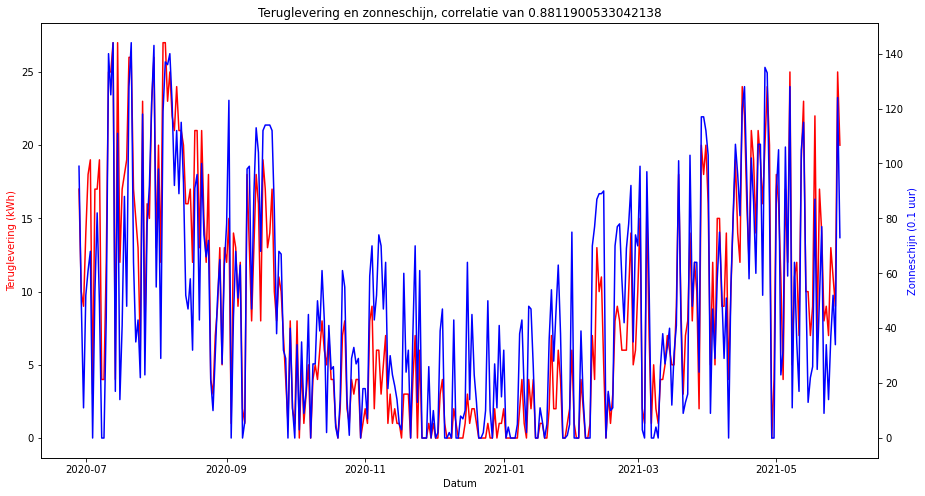

In [56]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.zonneschijn, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Zonneschijn (0.1 uur)', color='b')

plt.title(f'Teruglevering en zonneschijn, correlatie van {corr_zon}')
plt.show()

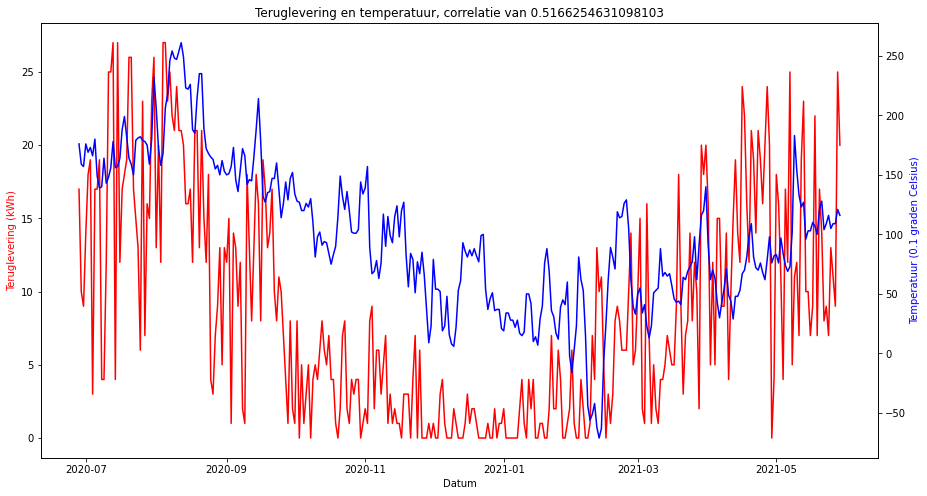

In [57]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.temp, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Temperatuur (0.1 graden Celsius)', color='b')

plt.title(f'Teruglevering en temperatuur, correlatie van {corr_temp}')
plt.show()

Er is te zien dat zonneschijn en teruglevering bijna op elkaar zitten; de teruglevering is door zonnepanelen, dus dat is logisch. Ook hebben temperatuur en teruglevering een verglijkbare richting; ook logisch, want wanneer de zon schijnt is het (vaak) warm.

**Te verklaren variabele: Teruglevering op basis van zonnepanelen**

Extra variabelen ARIMA model:
- Zonneschijn (0.1 uur)
- Temperatuur (0.1 graden Celsius)

## 3 Outliers

Outlier detectie wordt gedaan obv isolation forest en DBSCAN.

In [58]:
# Kolommen die in het model worden verwerkt
cols_model = ['teruglevering', 'temp', 'zonneschijn']

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
# Data schalen
scaler = StandardScaler()
np_scaled = scaler.fit_transform(ts[cols_model])#.values.reshape(-1, 1))
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']] = np_scaled
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].head()

,teruglevering_sc,temp_sc,zonneschijn_sc
2021-05-29,1.526239,0.274087,0.649640
2021-05-28,2.189649,0.354985,1.939885
2021-05-27,0.066736,0.160831,-0.337018
2021-05-26,0.332100,0.160831,0.118363
2021-05-25,0.597464,0.096114,-0.261121


In [61]:
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].describe()

,teruglevering_sc,temp_sc,zonneschijn_sc
count,3.360000e+02,3.360000e+02,3.360000e+02
mean,-1.771070e-16,8.921435e-17,2.180795e-16
std,1.001491e+00,1.001491e+00,1.001491e+00
min,-1.127403e+00,-2.751468e+00,-1.197181e+00
25%,-8.620385e-01,-7.290378e-01,-9.188927e-01
50%,-1.986282e-01,-9.803969e-02,-1.599253e-01
75%,7.301462e-01,7.473360e-01,6.749389e-01
max,2.455013e+00,2.620106e+00,2.445863e+00


### 3.1 Isolation forest

- Anomaly = -1

In [62]:
from sklearn.ensemble import IsolationForest

In [63]:
cols_model_scaled = ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']

In [64]:
# Initialiseer en fit model
outliers_fraction = float(.05) # 1% van de data wordt gedefinieerd als outlier
model =  IsolationForest(contamination = outliers_fraction)
model.fit(ts[cols_model_scaled])

IsolationForest(contamination=0.05)

In [65]:
# Predict outliers
ts['anomaly_if'] = model.predict(ts[cols_model_scaled])
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc', 'anomaly_if']].head()

,teruglevering_sc,temp_sc,zonneschijn_sc,anomaly_if
2021-05-29,1.526239,0.274087,0.649640,1
2021-05-28,2.189649,0.354985,1.939885,1
2021-05-27,0.066736,0.160831,-0.337018,1
2021-05-26,0.332100,0.160831,0.118363,1
2021-05-25,0.597464,0.096114,-0.261121,1


In [66]:
ts.value_counts('anomaly_if')

anomaly_if
 1    319
-1     17
dtype: int64

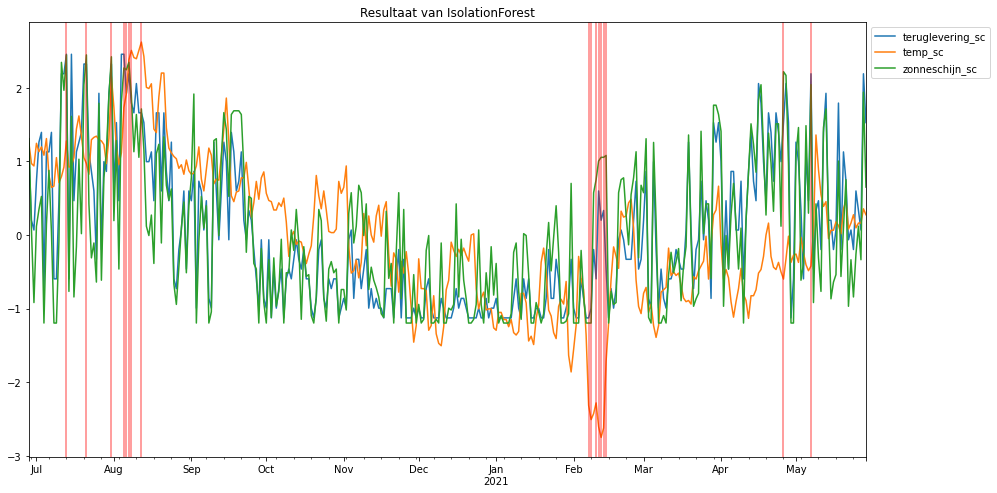

In [116]:
fig, ax = plt.subplots()

ts_anom = ts[ts['anomaly_if'] == -1]

ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].plot(ax = ax)

for col in ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']:
    ax.scatter(ts_anom.index,
               ts_anom[col],
               c = 'r',
               label = 'Anomaly')

# for date in ts_anom.index:
#     plt.axvline(date, color = 'r', alpha = 0.5)

plt.title('Resultaat van IsolationForest')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### 3.2 DBSCAN

In [74]:
from sklearn.cluster import DBSCAN
from collections import Counter

In [124]:
# Initialiseer en fit model
model = DBSCAN(eps=0.8, min_samples=10)
model.fit(ts[cols_model_scaled])

DBSCAN(eps=0.8, min_samples=10)

In [125]:
# Outliers
print(Counter(model.labels_))
ts['anomaly_db'] = model.labels_

Counter({0: 329, -1: 7})


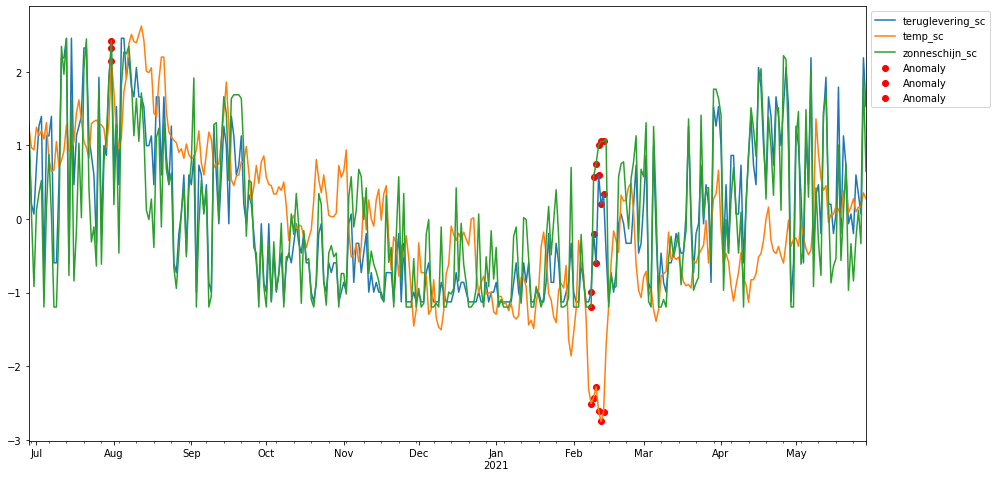

In [126]:
fig, ax = plt.subplots()

ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].plot(ax = ax)

ts_anom = ts[ts['anomaly_db'] == -1]

for col in ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']:
    ax.scatter(ts_anom.index,
               ts_anom[col],
               c = 'r',
               label = 'Anomaly')

# for date in ts_anom.index:
#     plt.axvline(date, color = 'r', alpha = 0.5)
    
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## 4 Model

- Te verklaren variabele: Teruglevering
- Extra verklarende variabelen: Zonneschijn en temperatuur.
- Misschien Fourier terms om seizoen te modelleren, omdat er maar één jaar aan data is?

### 4.1 Stationairiteit
Seasonal decompose kan niet uitgevoerd worden omdat er niet genoeg data is.

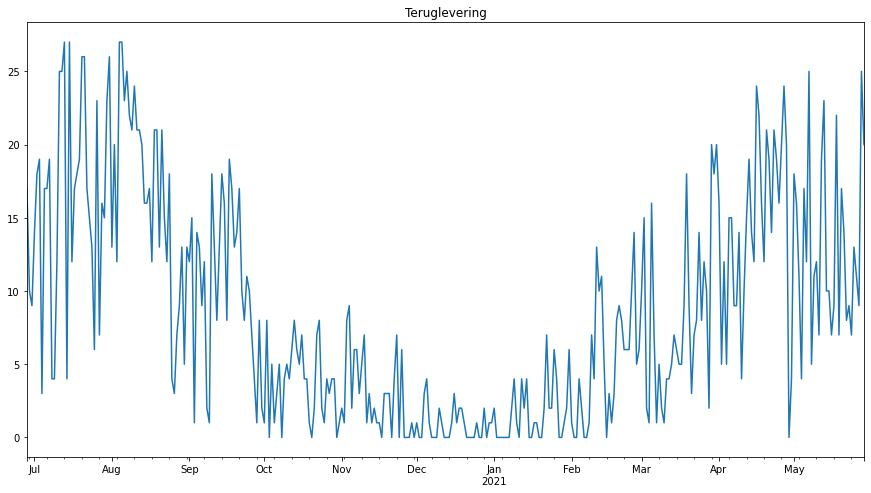

In [115]:
ts['teruglevering'].plot()
plt.title('Teruglevering')
plt.show()

In [116]:
# Voer adfullertest uit
res_stat = adfuller(ts['teruglevering'])

print('P-waarde adfuller test:')
print(res_stat[1])
print('In combinatie met de plot is conclusie dat de tijdreeks voor teruglevering stationair is.')

P-waarde adfuller test:
0.1386891300107993
In combinatie met de plot is conclusie dat de tijdreeks voor teruglevering stationair is.


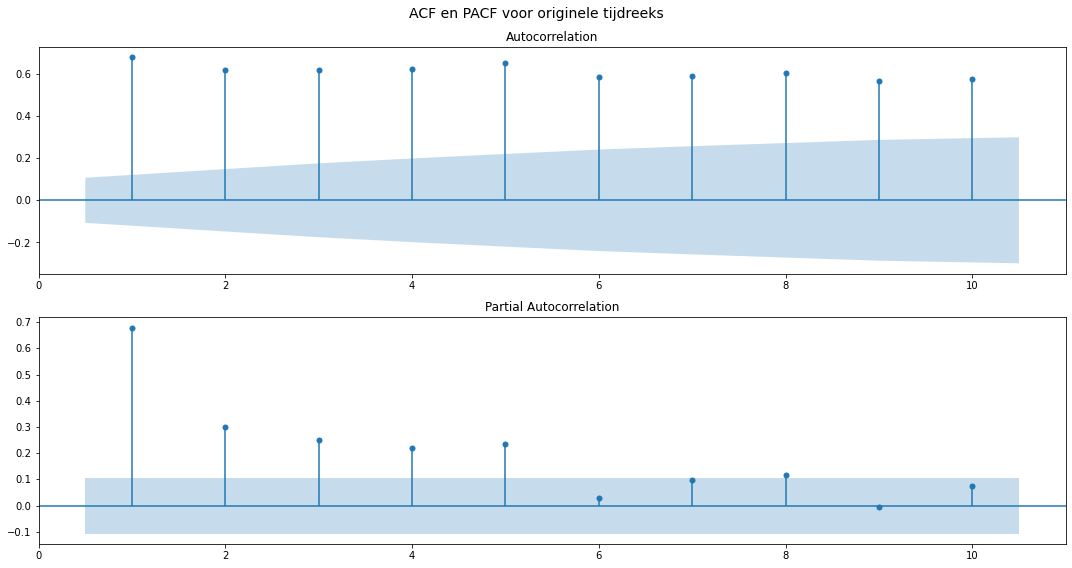

In [127]:
# ACF en PACF voor gas
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor originele tijdreeks', size = 14)
plt.tight_layout()
plt.show()

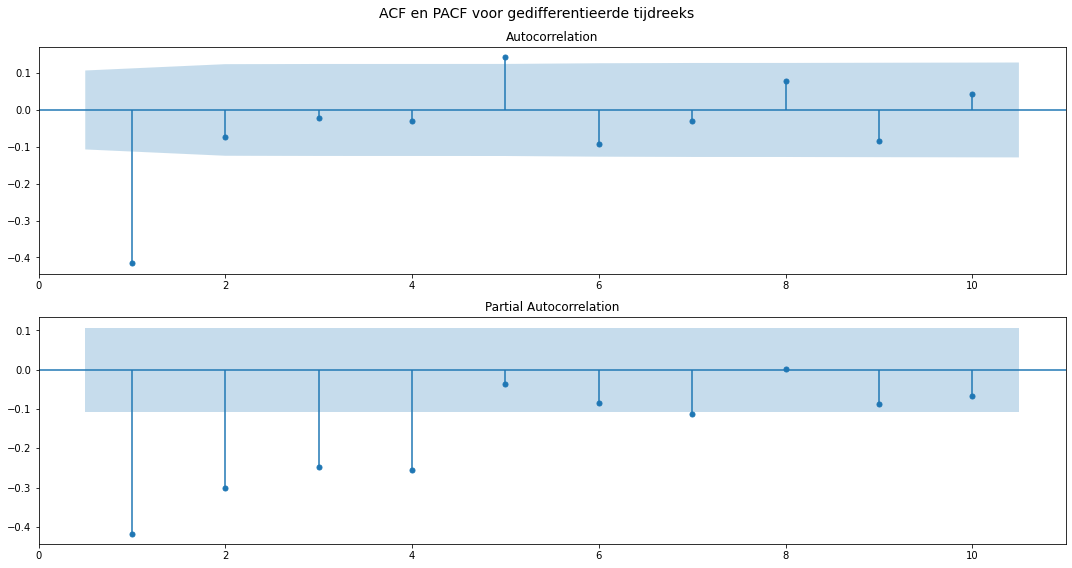

In [126]:
# ACF en PACF voor gas
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor gedifferentieerde tijdreeks', size = 14)
plt.tight_layout()
plt.show()